## Libraries 

In [1]:
import numpy as np
import pandas as pd

# Dataset

In [2]:
# for the label datasets
X = pd.read_csv('Final_ToBeLabelled(ICD_INCLUDED)_EN.csv', sep='\t').drop(labels=['ICD','index_exam'], axis =1)
y = pd.read_csv('Final_ToBeLabelled(ICD_INCLUDED)_EN.csv', sep='\t')['ICD'].astype('category') # as category 
# for the unlabeled target
X_unlab = pd.read_csv('Final_Unlabelled_EN.csv', sep='\t').drop(labels=['ICD','index_exam'], axis =1)

# Preprocessing 

In [3]:
# preprocessing on X_train and X_unlab (label encoding)
X_sex = pd.get_dummies(data=X['Weiblich/Männlich'])
X_unlab_sex = pd.get_dummies(data=X_unlab['Weiblich/Männlich'])
X_age = pd.get_dummies(data=X['age'])
X_unlab_age = pd.get_dummies(data=X_unlab['age'])

In [4]:
# preprocessing
# preprocessing on X and X_unlab (label encoding)
X_sex = pd.get_dummies(data=X['Weiblich/Männlich'])
X_unlab_sex = pd.get_dummies(data=X_unlab['Weiblich/Männlich'])
X_age = pd.get_dummies(data=X['age'])
X_unlab_age = pd.get_dummies(data=X_unlab['age'])

In [5]:
# drop the UUID, age and sex columns from the data
X_unlab.drop(labels=['UUID', 'age','Weiblich/Männlich'], axis=1, inplace=True)
X.drop(labels=['age','Weiblich/Männlich', 'UUID'],axis=1,inplace=True)

In [6]:
# after the preprocessing,instantiate call it X_train
X_train = pd.concat([X_sex,X_age,X],axis=1).astype('float')
# after the preprocessing,instantiate call it X_unlab_p
X_unlab_p = pd.concat([X_unlab_sex,X_unlab_age,X_unlab],axis=1).astype('float')
X_unlab_p.shape, X_train.shape

((17174, 22), (192, 22))

# Model (S3VM)

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
# Using the Transductive Support Machine (S3VM)
from sklearn.svm import SVC
from sklearn.semi_supervised import SelfTrainingClassifier
# using the Self Learning Framework
base_model = SVC(kernel='linear', probability=True, C=1)
ssmodel = SelfTrainingClassifier(base_estimator=base_model)
# scale our dataset
from sklearn.preprocessing import StandardScaler
scale = StandardScaler().fit_transform(X_train)
# model learning
ssmodel.fit(X_train,y)

SelfTrainingClassifier(base_estimator=SVC(C=1, kernel='linear',
                                          probability=True))

# Making Predictions on the Unlabeled dataset

In [9]:
# Predict on Unlabeled dataset after the trainning
labels = ssmodel.predict(X_unlab_p)

In [10]:
# Probability of predicting target for each sample provided
clp = ssmodel.predict_proba(X_unlab_p)
clp

array([[0.00469109, 0.00490869, 0.00398537, ..., 0.00450686, 0.0030542 ,
        0.00331667],
       [0.00419838, 0.0046785 , 0.00505702, ..., 0.0042389 , 0.00345515,
        0.00267962],
       [0.00500645, 0.00436134, 0.00473257, ..., 0.00484745, 0.00346903,
        0.00325788],
       ...,
       [0.00491568, 0.00413441, 0.00583951, ..., 0.00482594, 0.00386803,
        0.0027572 ],
       [0.00454673, 0.00468694, 0.00461048, ..., 0.00434919, 0.00340434,
        0.00337919],
       [0.00369896, 0.0039858 , 0.00483889, ..., 0.00355741, 0.00342136,
        0.00330699]])

In [11]:
df = pd.DataFrame(clp, columns=y[:])
df.head()

ICD,G58.0,M48.00,M18.0,M24.68,M42.97,M54.99,G56.9,M40.50,M93.9,S13.4,...,M79.18,M75.3,M51.2,M40.56,M41.00,Q66.8,M40.46,M40.24,M17.0,M62.48
0,0.004691,0.004909,0.003985,0.008582,0.003719,0.005263,0.004120,0.004460,0.005724,0.004992,...,0.004659,0.004912,0.003805,0.006039,0.003907,0.003578,0.006863,0.004507,0.003054,0.003317
1,0.004198,0.004678,0.005057,0.010600,0.004828,0.003711,0.003250,0.003088,0.003774,0.004014,...,0.004005,0.003563,0.004514,0.005507,0.003003,0.003260,0.008414,0.004239,0.003455,0.002680
2,0.005006,0.004361,0.004733,0.008775,0.005033,0.005263,0.003934,0.004284,0.004310,0.005040,...,0.004105,0.004388,0.004325,0.005213,0.004080,0.004308,0.006425,0.004847,0.003469,0.003258
3,0.004228,0.004469,0.005366,0.008991,0.004961,0.004624,0.003646,0.003602,0.003890,0.004216,...,0.004395,0.004101,0.004394,0.005824,0.003558,0.003571,0.007300,0.004232,0.003695,0.002913
4,0.005027,0.004399,0.004043,0.007286,0.003950,0.006373,0.004527,0.005106,0.005917,0.005474,...,0.004671,0.005527,0.003608,0.006034,0.004549,0.004355,0.005555,0.004781,0.003150,0.003609


### Probability of predicting target for the unlabelled dataset (ICD)

In [12]:
# maximum value predicted for each label
maximum_value = df[df.columns].max(axis=1)
maximum_value = pd.DataFrame(data=maximum_value, columns=['Maximum_value'])
# dataframe of the predicted Label
df_l = pd.DataFrame(data=labels, columns=['Predicted Labels'])

# Confidence

In [13]:
# DataFrame of the Maximum probabiliy of predicting each label and the Label that was predicted...
df_la_max =pd.concat([df_l,maximum_value,df], axis=1)
df_la_max.sample(frac=.2)

,Predicted Labels,Maximum_value,G58.0,M48.00,M18.0,M24.68,M42.97,M54.99,G56.9,M40.50,...,M79.18,M75.3,M51.2,M40.56,M41.00,Q66.8,M40.46,M40.24,M17.0,M62.48
16534,M42.16,0.012863,0.003929,0.004015,0.004649,0.006353,0.004126,0.006855,0.004153,0.004719,...,0.004983,0.005759,0.003580,0.006513,0.004488,0.003930,0.005005,0.004059,0.003454,0.003196
9728,M71.2,0.011307,0.004579,0.004571,0.004775,0.007462,0.003972,0.005491,0.004302,0.004302,...,0.004873,0.005423,0.003710,0.007009,0.003851,0.003656,0.006283,0.004230,0.003442,0.003438
65,M99.71,0.012288,0.004393,0.004708,0.004534,0.007956,0.004338,0.005631,0.003961,0.004543,...,0.004735,0.004804,0.004125,0.005713,0.004202,0.003782,0.006434,0.004404,0.003510,0.003149
13352,M21.17,0.013275,0.005530,0.004472,0.003673,0.008379,0.004471,0.006610,0.004176,0.005265,...,0.003910,0.004888,0.003821,0.004668,0.004881,0.004929,0.005373,0.005276,0.002887,0.003500
12998,M54.16,0.016569,0.005326,0.004760,0.003995,0.010189,0.004809,0.004833,0.003625,0.004151,...,0.003669,0.003976,0.004370,0.004625,0.003785,0.004236,0.006759,0.005073,0.003075,0.003054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1651,S13.4,0.013309,0.005539,0.004447,0.004025,0.008529,0.004563,0.006155,0.004135,0.004894,...,0.003902,0.004939,0.003922,0.005151,0.004423,0.004674,0.005699,0.005154,0.003061,0.003529
2601,M40.34,0.010608,0.004069,0.004000,0.005694,0.007299,0.004997,0.005455,0.003871,0.003963,...,0.004703,0.004994,0.004328,0.006586,0.003810,0.003685,0.006222,0.004121,0.003965,0.003098
17082,M62.41,0.015000,0.005500,0.004602,0.004183,0.009469,0.004724,0.005052,0.004077,0.004233,...,0.003832,0.004361,0.004193,0.005198,0.003819,0.004325,0.006562,0.005055,0.003101,0.003282
8944,M54.16,0.017055,0.005221,0.004751,0.004098,0.010492,0.004796,0.004652,0.003547,0.003867,...,0.003558,0.003896,0.004314,0.004749,0.003591,0.004078,0.006968,0.004957,0.003018,0.002987


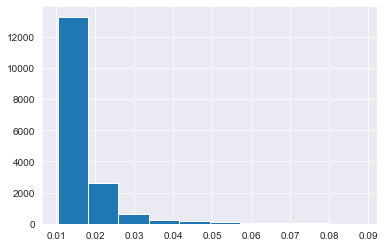

In [14]:
# visualization librarie
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')
# distribution of the maximum value
plt.hist(df_la_max['Maximum_value'])
plt.show()